In [1]:
### Imports
# Python Package Imports
import os
import socket
if socket.gethostname() == 'Desktop-CS1TBMI':
  os.environ['R_HOME'] = "C:/PROGRA~1/R/R-43~1.1"
else:
  os.environ['R_HOME'] = 'C:/Users/howey024/AppData/Local/Programs/R/R-4.3.2'
import glob
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.ipython.ggplot import image_png
from rpy2.robjects.packages import importr, data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(
c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\rpy2\robjects\lib\ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.3
  warnings.warn(


In [2]:
### R Function Imports
base = importr('base')
utils = importr('utils')
stringr = importr('stringr')
readxl = importr('readxl')
tidyverse = importr('tidyverse')
QuICAnalysis = importr('QuICAnalysis')

In [3]:
### Data Import

# Get a list of folders to search for data
folders = next(os.walk('./data'))[1]
folders = ['./data/' + folder for folder in folders]

# Search folders for appropriately named excel files and store together in a list of dictionaries
dataset = []
for i,folder in enumerate(folders):
    print(folder)
    dataset.append({})

    plate_path = glob.glob(folder + '/*plate*.xlsx')[0].replace('\\', '/')
    raw_path = glob.glob(folder + '/*raw*.xlsx')[0].replace('\\', '/')
    replicate_path = glob.glob(folder + '/*replicate*.xlsx')[0].replace('\\', '/')

    plate_data = readxl.read_xlsx(plate_path)
    raw_data = readxl.read_xlsx(raw_path)
    replicate_data = readxl.read_xlsx(replicate_path)

    # List of dictionaries mimics original R script
    dataset[i]['Plate'] = plate_data
    dataset[i]['Raw'] = raw_data
    dataset[i]['Replicate'] = replicate_data

./data/20230320_P1
New names:
* `` -> `...1`
New names:
* `` -> `...2`
New names:
* `` -> `...1`
./data/20230706_M7
New names:
* `` -> `...1`
New names:
* `` -> `...2`
New names:
* `` -> `...1`
./data/20230808_M12
New names:
* `` -> `...1`
New names:
* `` -> `...2`
New names:
* `` -> `...1`


In [4]:
### Data Analysis and Decomposition

# Analyzing dataframes and storing in lists
my_norm_analysis = []
my_analysis = []
for data_dict in dataset:
    robjects.globalenv["AlternativeTime"] = QuICAnalysis.GetTime(data_dict['Raw'])

    meta = QuICAnalysis.GetCleanMeta(data_dict['Raw'], data_dict['Plate'], data_dict['Replicate'])
    clean_raw = QuICAnalysis.GetCleanRaw(meta, data_dict['Raw'])

    analysis = QuICAnalysis.GetAnalysis(clean_raw, 10, 10, 4)
    meta_analysis = base.cbind(meta,analysis)

    analysis_norm = QuICAnalysis.NormAnalysis(metadata = meta, data = meta_analysis, control_name = 'pos')

    my_norm_analysis.append(analysis_norm)
    my_analysis.append(meta_analysis)

In [5]:
### Convert R Dataframes to Pandas Dataframes
my_df = pd.DataFrame()
for norm_analysis in my_norm_analysis:
  with (robjects.default_converter + pandas2ri.converter).context():
    dataframe = robjects.conversion.get_conversion().rpy2py(norm_analysis)
  my_df = pd.concat((my_df, dataframe), axis=0)
dataframe = my_df
print(dataframe)

    well content  replicate content_replicate  format  TimeToThreshold  \
1    A01     neg        1.0             neg_1    96.0         0.000000   
2    A02     neg        1.0             neg_1    96.0         0.000000   
3    A03     pos        1.0             pos_1    96.0         1.121294   
4    A04     pos        1.0             pos_1    96.0         0.690027   
5    A05     pos        1.0             pos_1    96.0         0.905660   
..   ...     ...        ...               ...     ...              ...   
340  P15      96        8.0              96_8   384.0         2.707692   
341  P16      97        8.0              97_8   384.0         1.517949   
342  P17      98        8.0              98_8   384.0         0.000000   
343  P18      99        8.0              99_8   384.0         0.000000   
344  P19      91        8.0              91_8   384.0         0.000000   

          RAF       MPR        MS  
1    0.000000  0.094896  0.008785  
2    0.000000  0.096728  0.006314  
3  

In [6]:
# Separate into classes and create training data
positive_samples = dataframe.loc[dataframe['content'] == 'pos']
negative_samples = dataframe.loc[dataframe['content'] == 'neg']
unlabeled_samples = dataframe.loc[dataframe['content'] != 'neg']
unlabeled_samples = unlabeled_samples.loc[unlabeled_samples['content'] != 'pos']

# Select out features we want to inspect
x_pos = np.asarray(positive_samples[['TimeToThreshold', 'RAF', 'MPR', 'MS']])
x_neg = np.asarray(negative_samples[['TimeToThreshold', 'RAF', 'MPR', 'MS']])
x_unknown = np.asarray(unlabeled_samples[['TimeToThreshold', 'RAF', 'MPR', 'MS']])

# Create labels
y_pos = np.ones(len(x_pos))
y_neg = np.zeros(len(x_neg))
y_unknown = np.full(len(x_unknown), 2)

# Combine into unified labeled dataset
x = np.concatenate((x_pos, x_neg, x_unknown))
y = np.concatenate((y_pos, y_neg, y_unknown))

print('Dataset shape: ' + str(x.shape))
print('Labels shape: ' + str(y.shape))

Dataset shape: (536, 4)
Labels shape: (536,)


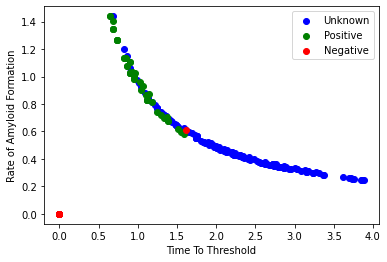

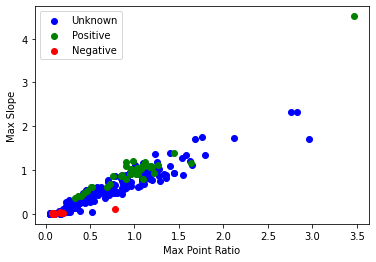

In [7]:
### Plot the data to show separability
fig, ax = plt.subplots()
ax.scatter(x_unknown[:,0], x_unknown[:,1], c='b')
ax.scatter(x_pos[:,0], x_pos[:,1], c='g')
ax.scatter(x_neg[:,0], x_neg[:,1], c='r')
ax.legend(['Unknown', 'Positive', 'Negative'])
plt.xlabel('Time To Threshold')
plt.ylabel('Rate of Amyloid Formation')
plt.show()

fig, ax = plt.subplots()
ax.scatter(x_unknown[:,2], x_unknown[:,3], c='b')
ax.scatter(x_pos[:,2], x_pos[:,3], c='g')
ax.scatter(x_neg[:,2], x_neg[:,3], c='r')
ax.legend(['Unknown', 'Positive', 'Negative'])
plt.xlabel('Max Point Ratio')
plt.ylabel('Max Slope')
plt.show()

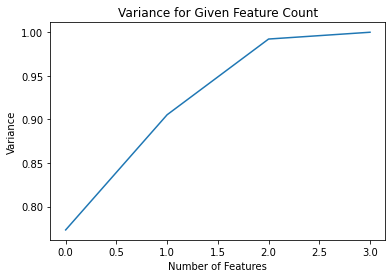

In [8]:
### Run a principle component analysis
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler().fit(x)
x_scaled = scaler.transform(x)

pca = PCA()
pca.fit(x_scaled)

plt.plot(np.arange(len(pca.explained_variance_ratio_.cumsum())), pca.explained_variance_ratio_.cumsum())
plt.title('Variance for Given Feature Count')
plt.xlabel('Number of Features')
plt.ylabel('Variance')
plt.show()

# From this we know that we need to only keep 2 features
pca = PCA(n_components = 2)
pca.fit(x_scaled)
x_pca = pca.transform(x_scaled)
x = x_pca

[[ 2.05649434 -0.22710355]
 [-1.26362905  0.13954556]]


c:\Users\kyleh\anaconda3\envs\tf-keras-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


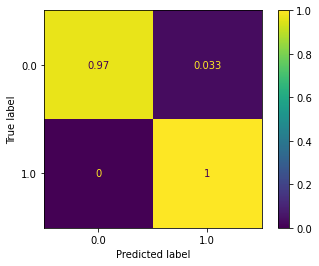

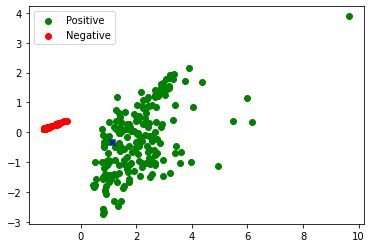

Misclassified points are represented by a blue x


In [9]:
### Attempt an unsupervised learning approach
from sklearn.cluster import KMeans
from sklearn.metrics import ConfusionMatrixDisplay

kmc = KMeans(n_clusters=2, random_state=7).fit(x)
preds = kmc.predict(x)

# Can't control which cluster gets which label, so if its exactly wrong, it just flipped the labels
if len(preds[preds != y]) > len(y) / 2:
  preds = 1-preds

centers = kmc.cluster_centers_
print(centers)

# Separate into positive and negative clusters
pred_pos = x[preds == 1]
pred_neg = x[preds == 0]

# Find data and predictions with known labels
indices = np.arange(len(y))
index_pos = indices[np.where(y == 1, True, False)]
index_neg = indices[np.where(y == 0, True, False)]

x_labeled = np.concatenate((x[index_pos], x[index_neg]))
y_labeled = np.concatenate((y[index_pos], y[index_neg]))
preds_labeled = np.concatenate((preds[index_pos], preds[index_neg]))

misclassed = []
for i,pred in enumerate(preds_labeled):
   if pred != y_labeled[i]:
      misclassed.append(x[i])
misclassed = np.array(misclassed)

# Plot confusion matrix on labeled data - should be perfect
ConfusionMatrixDisplay.from_predictions(y_labeled, preds_labeled, normalize='true')

# Show how KMeans divided the dataset
fig, ax = plt.subplots()
ax.scatter(pred_pos[:, 0], pred_pos[:, 1], c='g')
ax.scatter(pred_neg[:, 0], pred_neg[:, 1], c='r')
ax.scatter(misclassed[:, 0], misclassed[:, 1], c='b', marker='x')
ax.legend(['Positive', 'Negative'])
plt.show()

# fig, ax = plt.subplots()
# ax.scatter(pred_pos[:, 2], pred_pos[:, 3], c='g')
# ax.scatter(pred_neg[:, 2], pred_neg[:, 3], c='r')
# ax.scatter(misclassed[:, 2], misclassed[:, 3], c='b', marker='x')
# ax.legend(['Positive', 'Negative'])
# plt.xlabel('Max Point Ratio')
# plt.ylabel('Max Slope')
# plt.show()

print('Misclassified points are represented by a blue x')

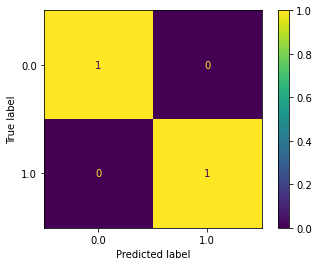

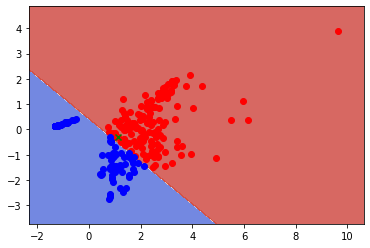

In [12]:
### Try a small supervised approach
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

# Create a training/testing dataset
x_train, x_test, y_train, y_test = train_test_split(x_labeled, y_labeled, test_size=0.2)

# Train the model
svc = LinearSVC()
svc = svc.fit(x_train, y_train)
preds = svc.predict(x_test)

# Plot a confusion matrix on the known data
ConfusionMatrixDisplay.from_predictions(preds, y_test, normalize='true')

# Plot on the entire dataset
preds = svc.predict(x)

# Separate into positive and negative clusters
pred_pos = x[preds == 1]
pred_neg = x[preds == 0]

# Checking labeled predictions
preds_labeled = np.concatenate((preds[index_pos], preds[index_neg]))
misclassed = []
for i,pred in enumerate(preds_labeled):
   if pred != y_labeled[i]:
      misclassed.append(x[i])
misclassed = np.array(misclassed)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Set-up grid for plotting.
X0, X1 = x[:, 0], x[:, 1]
xx, yy = make_meshgrid(X0, X1)

# Show how KMeans divided the dataset
fig, ax = plt.subplots()
plot_contours(ax, svc, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(pred_pos[:, 0], pred_pos[:, 1], c='r')
ax.scatter(pred_neg[:, 0], pred_neg[:, 1], c='b')
if len(misclassed) > 0:
  ax.scatter(misclassed[:, 0], misclassed[:, 1], c='g', marker='x')
plt.show()

# fig, ax = plt.subplots()
# ax.scatter(pred_pos[:, 2], pred_pos[:, 3], c='g')
# ax.scatter(pred_neg[:, 2], pred_neg[:, 3], c='r')
# if(len(misclassed > 0)):
#   ax.scatter(misclassed[:, 2], misclassed[:, 3], c='b', marker='x')
# ax.legend(['Positive', 'Negative'])
# plt.xlabel('Max Point Ratio')
# plt.ylabel('Max Slope')
# plt.show()